# Examine epistasis for DHFR mutations in the background of TYMS R166Q and TYMS Q33S

In this notebook, we compute epistasis across the entire DMS dataset. More specifically, for each DHFR mutation we calculate the epistasis to the two TYMS backgrounds (Q33S and R166Q). We assess the statistical significance of all epistatic measurements, examine the statistical distribution of epistatic effects, and visualize the pattern of epistasis as a heat map. Finally, we use k-means clustering to identify DHFR positions with similar patterns of epistasis. When mapped to a reference DHFR structure, we find these positions cluster into structurally localized regions.

April 2022 - K. Reynolds and T. Nguyen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import pandas as pd
from datetime import date
import random
import copy
import pickle
import math
from Bio.PDB.PDBParser import PDBParser

from scipy import stats
from scipy.optimize import least_squares

#set up the plotting environment
import plot_style
plot_style.change_plot_defaults()

### Import all of the relevant data (growth rates as calculated in 2_DMSGrowthRates)

#### Relative growth rates (and errors) obtained by sequencing

In [2]:
#growth rates as calculated in 2_DMSGrowthRates.ipynb
#gr_mean only includes DHFR variants with three replicate measurements
# (mutations that were absent from the library or showed insufficient reads 
# to allow growth rate fitting in at lease one replicate are replaced with a nan)
#WT alleles at each position have a fitness of 1

fin = open('Output/grates.pkl','rb')
grate_data = pickle.load(fin)
gr_mean = grate_data['avg']
gr_std = grate_data['std']
WTAAmask = grate_data['WTAAmask']

#experimental parameters
TYMS_mut = list(gr_mean.keys())

#define the size of the mutational space
#and specify the sequence (and range) of each sublibrary
Npos = 159 
AA = 'GAVLMIFYWKRHDESTCNQP*' #here we order the amino acids by biochemical similarity
NAA = len(AA)
NAA_nostop = NAA - 1
wt_aa_sequence= {}
wt_aa_sequence['sl1']= 'MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPV'
wt_aa_sequence['sl2']= 'IMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDE'
wt_aa_sequence['sl3']= 'AIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVE'
wt_aa_sequence['sl4']= 'GDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR*'
wt_aa_seqfull = wt_aa_sequence['sl1']+wt_aa_sequence['sl2']+wt_aa_sequence['sl3']+wt_aa_sequence['sl4']

### Calculate Epistasis to TYMS R166Q and TYMS Q33S

#### First, we filter the growth rate data to exclude stop codons and mutations with growth rates less than zero 

(Following the rationale that we want to focus our attention on missense mutations, and those variants with negative growth rates are some of our least confident measurements)

In [3]:
#Filter the data, excluding:
#position 1 of DHFR, growth rates less than zero, and stop codons.
#gr_mean has already been filtered to assign np.nan to mutations missing from the library
#or mutations that "drop out" before we collect 3 time points.
gr_filt = {}
gr_filt_std = {}
for ts in TYMS_mut:
    gr_filt[ts] = np.copy(gr_mean[ts][1:,:-1])
    gr_filt[ts][gr_mean[ts][1:,:-1] < 0] = np.nan
    
    gr_filt_std[ts] = np.copy(gr_std[ts][1:,:-1])
    gr_filt_std[ts][gr_mean[ts][1:,:-1] < 0] = np.nan

#Create a list of mutants for which growth rates were measured (after applying all filters)
#in all three TYMS backgrounds
mutMask = np.zeros_like(gr_filt['WT'])
Nmut = np.sum(~(WTAAmask[1:,:-1]))
for pos_ix in range(Npos-1):
    for aa_ix in range(NAA_nostop):
        if (~np.isnan(gr_filt[TYMS_mut[0]][pos_ix,aa_ix]) and ~np.isnan(gr_filt[TYMS_mut[1]][pos_ix,aa_ix])) and \
            (~np.isnan(gr_filt[TYMS_mut[2]][pos_ix,aa_ix])):
            mutMask[pos_ix,aa_ix] = 1

mutMask = mutMask == 1
mutWTMask = mutMask & ~(WTAAmask[1:,:-1]) #the set of non-WT alleles for which we have accurate measurements
                                          #across all three TYMS backgrounds

print('%i of %i (%1.2f) coding mutations have growth rate measurements in all three TYMS backgrounds' % \
      (np.sum(mutWTMask),Nmut, np.sum(mutWTMask)/Nmut))

2696 of 3002 (0.90) coding mutations have growth rate measurements in all three TYMS backgrounds


#### Now, compute epistasis and plot the distribution of epistatic effects in each TYMS background.

As suggested by the model, we observe strong positive epistasis to TYMS R166Q, and weaker epistasis - including negative epistasis - to TYMS Q33S

***** Epistasis to Q33S:
min: -0.49, max: 0.67, avg: 0.01, std_dev: 0.07 
average error (std dev): 0.04
***** Epistasis to R166Q:
min: -0.40, max: 0.97, avg: 0.10, std_dev: 0.20
average error (std dev): 0.04


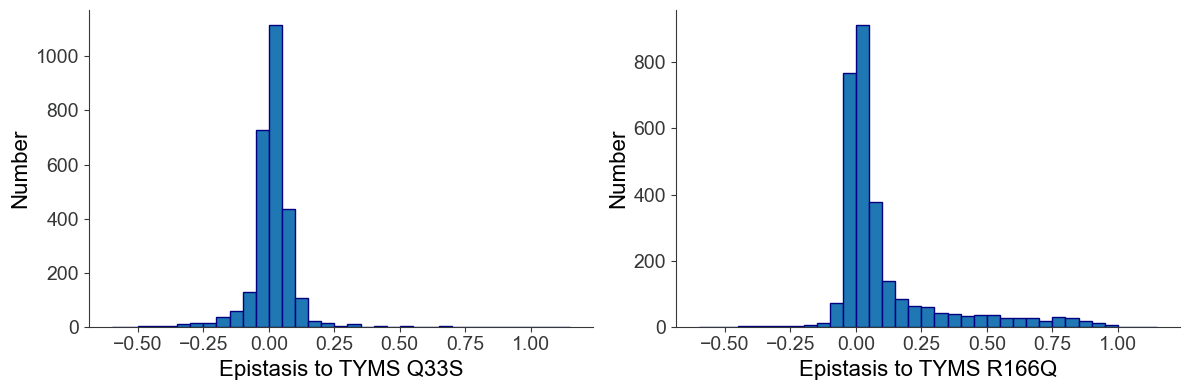

In [4]:
#calculate epistasis
epi, epi_std = {}, {}
epi['R166Q'] = gr_filt['R166Q'] - gr_filt['WT']
epi['Q33S'] = gr_filt['Q33S'] - gr_filt['WT']
epi_std['R166Q'] = np.sqrt((gr_filt_std['R166Q'])**2 + (gr_filt_std['WT'])**2)
epi_std['Q33S'] = np.sqrt((gr_filt_std['Q33S'])**2 + (gr_filt_std['WT'])**2)

#masked versions of the epistasis measurements that exclude WT (to prevent overcounting of zero epistasis)
epi_masked, epi_std_masked = {},{}
epi_masked['R166Q'] = np.ma.array(epi['R166Q'],mask=WTAAmask[1:,:-1],fill_value = np.nan).filled()
epi_masked['Q33S'] = np.ma.array(epi['Q33S'],mask=WTAAmask[1:,:-1],fill_value = np.nan).filled()
epi_std_masked['R166Q'] = np.ma.array(epi_std['R166Q'],mask=WTAAmask[1:,:-1],fill_value = np.nan).filled()
epi_std_masked['Q33S'] = np.ma.array(epi_std['Q33S'],mask=WTAAmask[1:,:-1],fill_value = np.nan).filled()

print("***** Epistasis to Q33S:")
print("min: %1.2f, max: %1.2f, avg: %1.2f, std_dev: %1.2f " % (np.nanmin(epi_masked['Q33S']),np.nanmax(epi_masked['Q33S']),\
                                                               np.nanmean(epi_masked['Q33S']), np.nanstd(epi_masked['Q33S'])))
print("average error (std dev): %1.2f" % np.nanmean(epi_std['Q33S']))

print("***** Epistasis to R166Q:")
print("min: %1.2f, max: %1.2f, avg: %1.2f, std_dev: %1.2f"% (np.nanmin(epi_masked['R166Q']),np.nanmax(epi_masked['R166Q']),\
                                                             np.nanmean(epi_masked['R166Q']), np.nanstd(epi_masked['R166Q'])))
print("average error (std dev): %1.2f" % np.nanmean(epi_std['R166Q']))

#plot
plt.figure(figsize = (12,4))
plt.subplot(121)
bin_edges = np.arange(-0.6,1.2,0.05)
plt.hist(epi_masked['Q33S'].flatten(),bins=bin_edges,edgecolor='navy')
plt.ylabel('Number',fontsize=16); plt.xlabel('Epistasis to TYMS Q33S',fontsize=16)

plt.subplot(122)
plt.hist(epi_masked['R166Q'].flatten(),bins=bin_edges,edgecolor='navy')
plt.ylabel('Number',fontsize=16); plt.xlabel('Epistasis to TYMS R166Q',fontsize=16)

plt.tight_layout()

For both TYMS backgrounds, the vast majority of mutations show little to no epistasis. As suggested by the modeling in 1_KGModel.ipynb, we see a large tail of DHFR mutations with positive epistasis to TYMS R166Q. For Q33S we observe mutations with both positive and negative epistasis. 

### Assess the statistical significance of epistasis across all mutations

To do this, we calculate a p-value describing the likelihood that the triplicate growth rate measurements (made in each TYMS background) are drawn from the same distribution. Practically this is implemented as a Welch's t-test across our triplicate relative growth rate measurements. To define the p-value threshold for significance, we determine a multiple-hypothesis testing adjusted p-value cutoff using the Sequential-Goodness-of-Fit (SGoF) method. 

In [5]:
# Performs binomial sequential goodness-of-fit (SGoF), a multiple hypothesis correction procedure for large numbers of 
# hypothesis tests. This function filters p-values that fail to meet a significance threshold or are likely to be
# significant only by chance.
# Input -- pvals: the 2D array of p-values calculated for the growth rate difference of each mutation
#          alpha: the significance threshold        
# Output -- pval_SGOF: the significance threshold after adjustment with SGOF

def binomial_SGoF(pvals,alpha=0.05):
    pvals_list = pvals.flatten()
    pvals_list.sort()
    total_tests = list(np.isnan(pvals_list)).index(True) - 1# Total tests executed, not considering points with no measurement
    sig_tests = sum(pvals_list <= alpha) # Total significant tests, as determined by alpha

    print('Tests: %i' % total_tests)
    print('Significant at a cutoff of alpha=%1.3f: %f' % (alpha,sig_tests))
    
    if total_tests > sig_tests:
        b_sig = 0 # Current number of rejected null hypotheses
        R = sig_tests # Current number of remaining tests to re-check
        
        # Probability that R sig tests could arise from random chance
        p = stats.binom_test(R, n=total_tests, p=alpha, alternative='greater') 
        while p < alpha: # Below our confidence threshold
            b_sig += 1 # Fully reject a null
            R -= 1 # Update remaining tests to re-check
            p = stats.binom_test(R, total_tests, p=alpha, alternative='greater')
        pval_SGoF = pvals_list[b_sig]
        print ('Number of sig measurements by SGOF is: %i' % b_sig)
        print('SGOF corrected pval is: %f' % pval_SGoF)
        return pval_SGoF
    else:
        print('Cannot use SGoF to correct for significance.')
        b_sig = np.nan
        return 0

***SGoF correction, TYMS Q33S:
Tests: 2697
Significant at a cutoff of alpha=0.050: 773.000000
Number of sig measurements by SGOF is: 619
SGOF corrected pval is: 0.035240
***Significantly epistatic mutations, TYMS Q33S:
280 (0.09) positive mut at 74 pos: 
4, 5, 7, 24, 25, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 115, 117, 119, 142, 144, 147, 156
95 (0.03) negative mut at 45 pos: 
2, 3, 4, 5, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 26, 28, 30, 31, 32, 33, 36, 37, 38, 40, 41, 56, 67, 69, 73, 84, 121, 122, 124, 125, 133, 135, 136, 137, 140, 148, 159
***SGoF correction, TYMS R166Q:
Tests: 2857
Significant at a cutoff of alpha=0.050: 1247.000000
Number of sig measurements by SGOF is: 1085
SGOF corrected pval is: 0.029330
***Significantly epistatic mutations, TYMS 

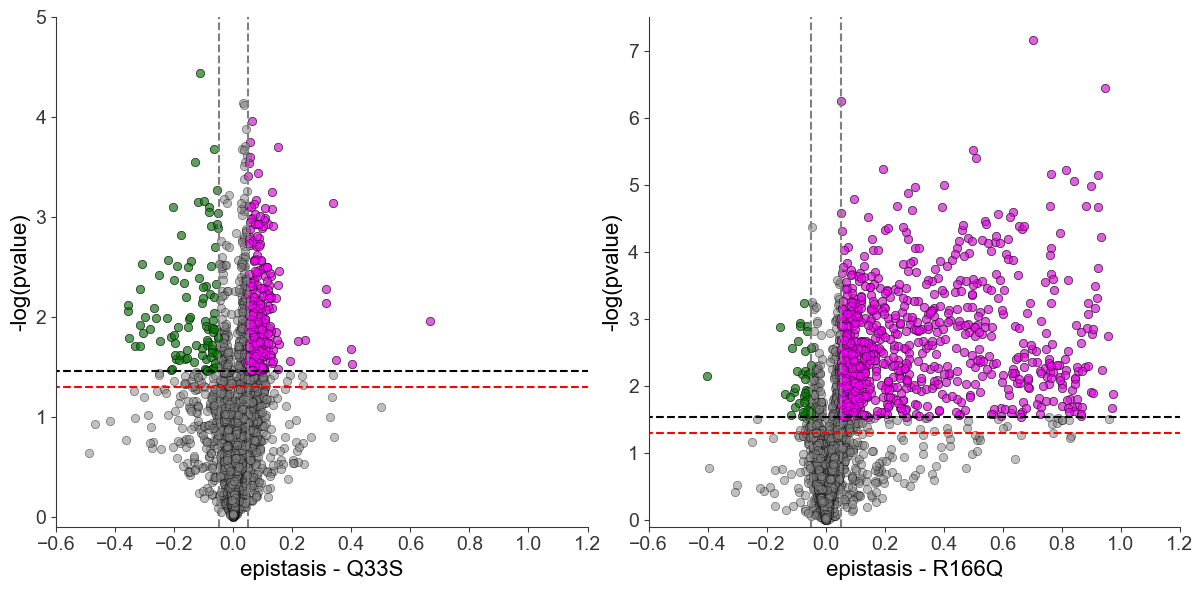

In [6]:
#calculate a p-value for each mutation using a Welch's t-test
epi_pvals = {}

#track significant mutations
sig_neg = {}; sig_neg_pos = {}
sig_pos = {}; sig_pos_pos = {}
epi_mask_sigpos = {}; epi_mask_signeg = {};
sig_thresh = {}

for ts in ['Q33S','R166Q']:
    epi_pvals[ts] = np.zeros_like(gr_filt[ts])
    epi_mask_sigpos[ts] = np.zeros_like(gr_filt[ts])
    epi_mask_signeg[ts] = np.zeros_like(gr_filt[ts])
    sig_neg[ts] = []; sig_neg_pos[ts] = [];
    sig_pos[ts] = []; sig_pos_pos[ts] = [];
    
    #determine the epistasis pvalue for each mutation
    for p in range(Npos - 1):
        for a in range(NAA_nostop):
            t,pval = stats.ttest_ind_from_stats(gr_filt['WT'][p,a],gr_filt_std['WT'][p,a],3,\
                                                gr_filt[ts][p,a],gr_filt_std[ts][p,a],3, \
                                                equal_var=False)
            epi_pvals[ts][p,a] = pval
    
    #determine the p-value cutoff using SGoF
    print('***SGoF correction, TYMS %s:' % ts)
    sig_thresh[ts] = binomial_SGoF(epi_pvals[ts])
    
    #store significantly epistatic mutations
    for p in range(Npos-1):
        for a in range(NAA_nostop):
            if epi_pvals[ts][p,a] < sig_thresh[ts]:
                if epi[ts][p,a] > 0.05: #we also set an empirical threshold on the amount of observed epi
                    sig_pos[ts].append(str(p+2)+AA[a])
                    epi_mask_sigpos[ts][p,a] = 1
                elif epi[ts][p,a] < -0.05: #we also set an empirical threshold on the amount of observed epi 
                    sig_neg[ts].append(str(p+2)+AA[a])
                    epi_mask_signeg[ts][p,a] = 1
    sig_pos_pos[ts] = list(set([int(p[:-1]) for p in sig_pos[ts]]))
    sig_neg_pos[ts] = list(set([int(p[:-1]) for p in sig_neg[ts]]))
    sig_pos_pos[ts].sort(); sig_neg_pos[ts].sort()
    print('***Significantly epistatic mutations, TYMS %s:' % ts)
    print('%i (%1.2f) positive mut at %i pos: ' % (len(sig_pos[ts]),len(sig_pos[ts])/Nmut, \
                                                   len(sig_pos_pos[ts])))
    print(', '.join([str(p) for p in sig_pos_pos[ts]]))
    print('%i (%1.2f) negative mut at %i pos: ' % (len(sig_neg[ts]),len(sig_neg[ts])/Nmut, \
                                                   len(sig_neg_pos[ts])))
    print(', '.join([str(p) for p in sig_neg_pos[ts]]))

    epi_mask_sigpos[ts] = (epi_mask_sigpos[ts] == 1)
    epi_mask_signeg[ts] = (epi_mask_signeg[ts] == 1)
    
#Report on the number of significant epistatic mutations that switch sign
sign_switch_mut = (set(sig_neg['Q33S'])).intersection(set(sig_pos['R166Q']))
print('*** Mutations with statistically significant sign epistasis: ')
print('%i total: ' % len(sign_switch_mut))
print(', '.join(sign_switch_mut))
##### volcano plot of the results #####
plt.figure(figsize=(12,6))

#### TYMS Q33S
plt.subplot(121)
plt.plot(epi['Q33S'].flatten(), -np.log10(epi_pvals['Q33S'].flatten()),marker='o',markersize=6,color = 'grey', \
         mec='black',mew = 0.5, linewidth=0, alpha=0.5)
plt.plot(epi['Q33S'][epi_mask_sigpos['Q33S']].flatten(),-np.log10(epi_pvals['Q33S'])[epi_mask_sigpos['Q33S']].flatten(),\
         marker='o',markersize=6,color = 'magenta',mec='black',mew = 0.5, linewidth=0, alpha=0.5)
plt.plot(epi['Q33S'][epi_mask_signeg['Q33S']].flatten(),-np.log10(epi_pvals['Q33S'])[epi_mask_signeg['Q33S']].flatten(),\
         marker='o',markersize=6,color = 'green',mec='black',mew = 0.5, linewidth=0, alpha=0.5)

#annotate the graph
plt.plot([-0.05, -0.05],[-0.1,5], '--', color='grey')
plt.plot([0.05, 0.05],[-0.1,5], '--', color='grey')
plt.plot([-0.65,1.2],[-np.log10(0.05),-np.log10(0.05)], '--r')
plt.plot([-0.65,1.2],[-np.log10(sig_thresh['Q33S']),-np.log10(sig_thresh['Q33S'])], '--k')
plt.xlim([-0.6,1.2]); plt.ylim([-0.1,5])
plt.xlabel('epistasis - Q33S',fontsize=16); plt.ylabel('-log(pvalue)',fontsize=16)

#### TYMS R166Q
plt.subplot(122)
plt.plot(epi['R166Q'].flatten(), -np.log10(epi_pvals['R166Q'].flatten()),marker='o',markersize=6,color = 'grey', \
         mec='black',mew = 0.5, linewidth=0, alpha=0.5)
plt.plot(epi['R166Q'][epi_mask_sigpos['R166Q']].flatten(),-np.log10(epi_pvals['R166Q'])[epi_mask_sigpos['R166Q']].flatten(),\
         marker='o',markersize=6,color = 'magenta',mec='black',mew = 0.5, linewidth=0, alpha=0.5)
plt.plot(epi['R166Q'][epi_mask_signeg['R166Q']].flatten(),-np.log10(epi_pvals['R166Q'])[epi_mask_signeg['R166Q']].flatten(),\
         marker='o',markersize=6,color = 'green',mec='black',mew = 0.5, linewidth=0, alpha=0.5)

#annotate the graph
plt.plot([-0.05, -0.05],[-0.1,7.5], '--', color='grey')
plt.plot([0.05, 0.05],[-0.1,7.5], '--', color='grey')
plt.plot([-0.65,1.2],[-np.log10(0.05),-np.log10(0.05)], '--r')
plt.plot([-0.65,1.2],[-np.log10(sig_thresh['R166Q']),-np.log10(sig_thresh['R166Q'])], '--k')
plt.xlim([-0.6,1.2]); plt.ylim([-0.1,7.5])
plt.xlabel('epistasis - R166Q',fontsize=16); plt.ylabel('-log(pvalue)',fontsize=16)

plt.tight_layout()
plt.savefig('Figs/EpiVolcanoPlots.pdf')

### Display epistasis as a scatter plot, comparing relative growth rates in each TYMS background

<Figure size 2000x1000 with 0 Axes>

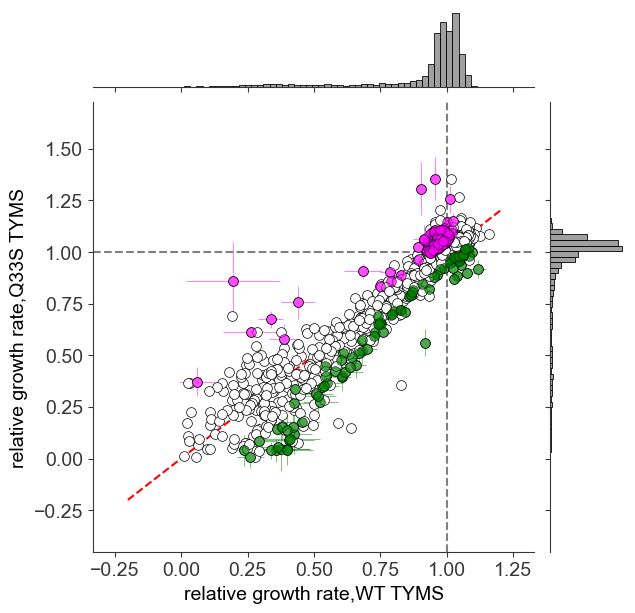

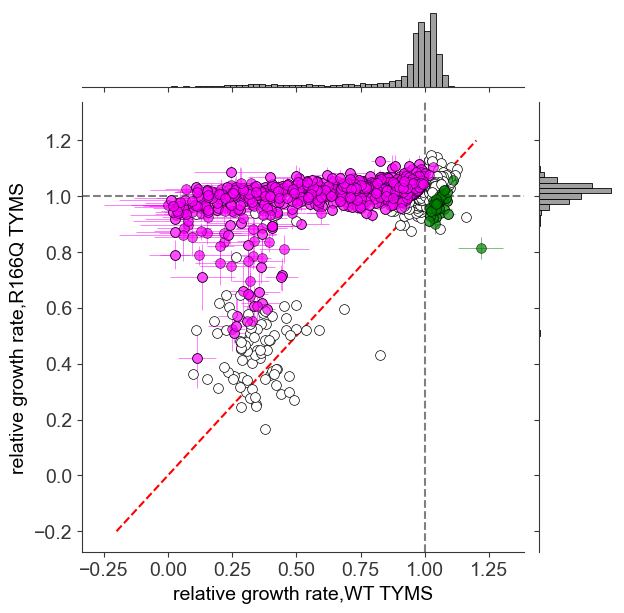

In [7]:
plt.figure(figsize=(20,10))
ts_pairs = (['WT','Q33S'],['WT','R166Q'])
plt.set_cmap('viridis')

for p in ts_pairs:
    x = gr_filt[p[0]][mutWTMask].flatten()   
    xerr = gr_filt_std[p[0]][mutWTMask].flatten()    
    y = gr_filt[p[1]][mutWTMask].flatten()
    yerr = gr_filt_std[p[1]][mutWTMask].flatten() 
    
    xpos = gr_filt[p[0]][epi_mask_sigpos[p[1]]].flatten()
    xposerr = gr_filt_std[p[0]][epi_mask_sigpos[p[1]]].flatten()
    ypos = gr_filt[p[1]][epi_mask_sigpos[p[1]]].flatten()
    yposerr = gr_filt_std[p[1]][epi_mask_sigpos[p[1]]].flatten()
    
    xneg = gr_filt[p[0]][epi_mask_signeg[p[1]]].flatten()
    xnegerr = gr_filt_std[p[0]][epi_mask_signeg[p[1]]].flatten()
    yneg = gr_filt[p[1]][epi_mask_signeg[p[1]]].flatten()
    ynegerr = gr_filt_std[p[1]][epi_mask_signeg[p[1]]].flatten()
    
    g = sns.jointplot(x=x,y=y,marginal_kws=dict(color='grey',bins=50))
    g.ax_joint.cla()
    g.ax_joint.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o',markersize=7,mec='black',color='white', mew=0.5,elinewidth=0.5)
    g.ax_joint.errorbar(xpos,ypos,xerr=xposerr,yerr=yposerr,fmt='o',markersize=7,mec='black',color='magenta', alpha=0.7,mew=0.5,elinewidth=0.5)
    g.ax_joint.errorbar(xneg,yneg,xerr=xnegerr,yerr=ynegerr,fmt='o',markersize=7,mec='black',color='green', alpha=0.7,mew=0.5,elinewidth=0.5)
    g.ax_joint.axhline(1.0, color='grey',linestyle='--')
    g.ax_joint.axvline(1.0, color='grey',linestyle='--')
    plt.sca(g.ax_joint)
    plt.plot([-0.2,1.2],[-0.2,1.2],'--r')
    g.ax_joint.set_xlabel(('relative growth rate,'+p[0]+' TYMS'),fontsize=14)
    g.ax_joint.set_ylabel(('relative growth rate,'+p[1]+' TYMS'),fontsize=14)
    fig = g.fig
    fig.savefig('Figs/GR_sigepi_%s.pdf' % p[1])
    #fig.savefig('Figs/GR_sigepi_%s.png' % p[1])

#### Display epistasis as a heatmap

We show two versions for each TYMS background: one map displaying all measurements, and a second with only statistically significant measurements

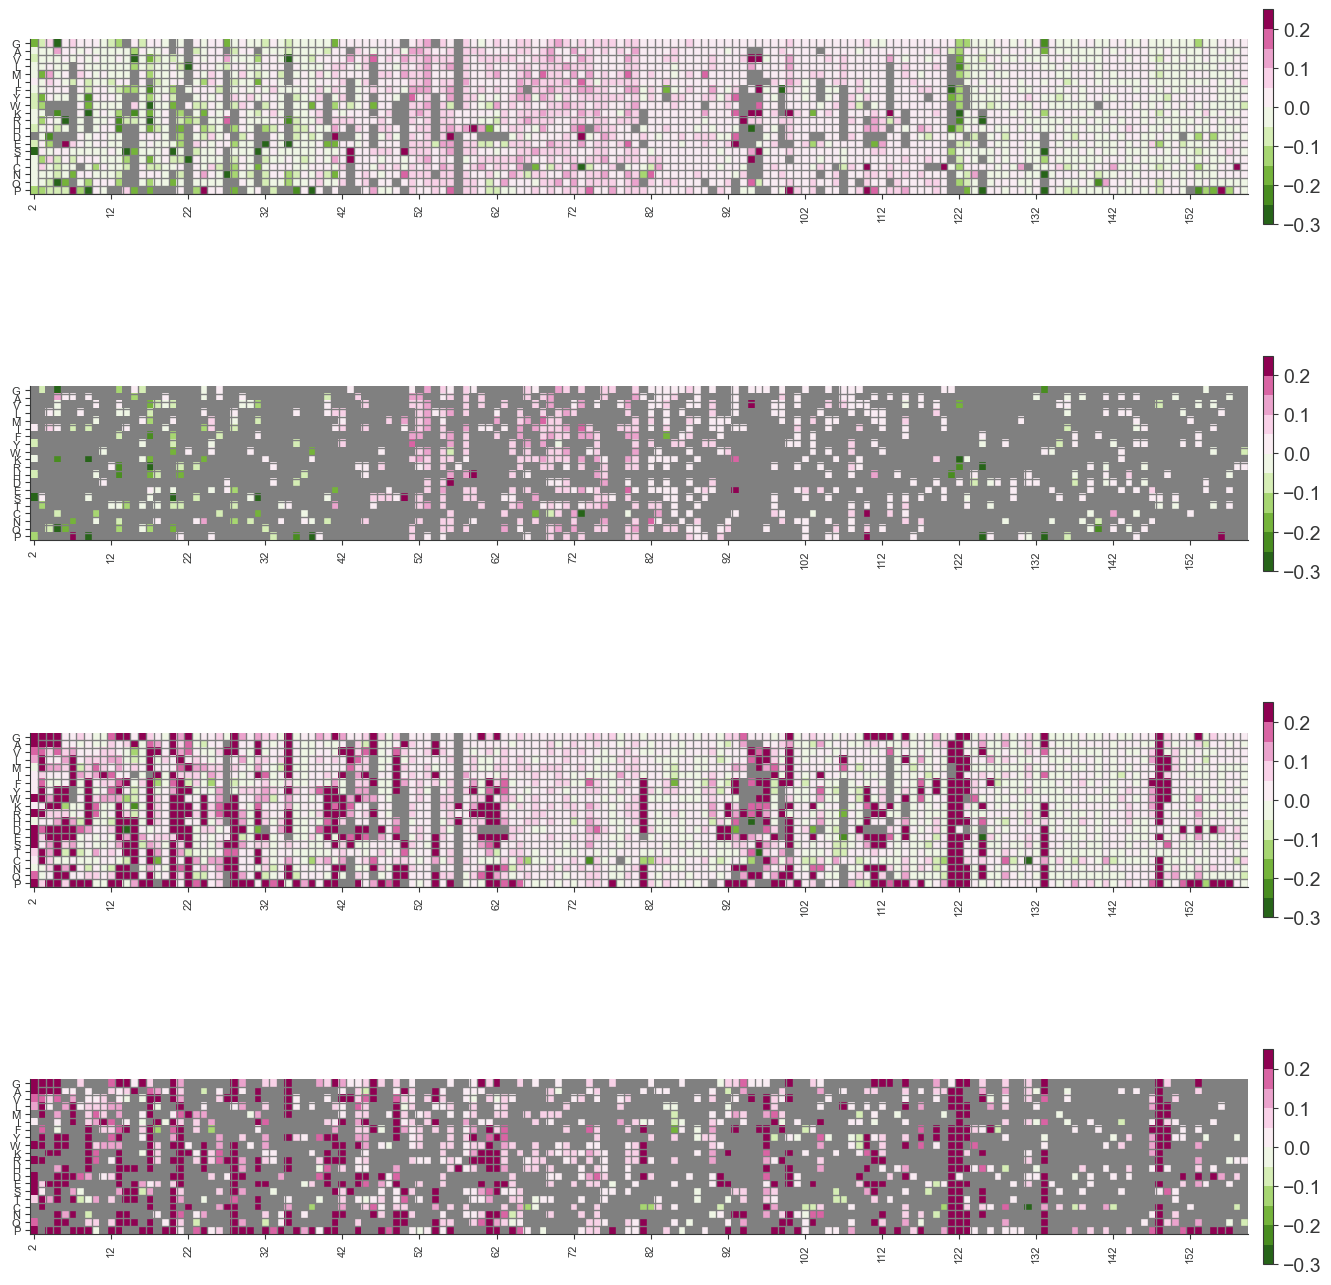

In [8]:
#masked epistasis arrays that include only significant measurements
epi_sig = {}
epi_sig['Q33S'] = np.ma.array(epi['Q33S'],mask=(epi_pvals['Q33S'] >= sig_thresh['Q33S']),fill_value = np.nan).filled()
epi_sig['R166Q'] = np.ma.array(epi['R166Q'],mask=(epi_pvals['R166Q'] >= sig_thresh['R166Q']),fill_value = np.nan).filled()


#create discretized colormap
bounds = np.arange(-0.3, 0.3, 0.05)
base = plt.cm.get_cmap('PiYG_r')
cmap_discrete = base(np.linspace(0,1,len(bounds)))
newmap = colors.ListedColormap(cmap_discrete)
newmap.set_bad(color='grey') 
#newmap.set_under(color='white')
norm = colors.BoundaryNorm(bounds,newmap.N)

#plot
plt.figure(num='epi_map',figsize = (15,15))
for t,ts in enumerate(['Q33S','R166Q']):
    plt.subplot(4,1,(1+(t*2)))
    plt.imshow(epi[ts].T,cmap=newmap,norm=norm)
    #draw on grey gridlines
    for i in range(1,Npos):
        plt.plot([i-0.5,i-0.5],[0-0.5,NAA_nostop-0.5],'grey',linewidth=1)
    for i in range(1,NAA):
        plt.plot([0+0.5,Npos-1.5],[i-0.5,i-0.5], 'grey',linewidth=1)
    plt.colorbar(shrink = 0.5, orientation = 'vertical', pad = 0.01)
    plt.xticks(np.arange(0,Npos-1,10),labels=[str(p) for p in range(2,Npos,10)],\
                     rotation='vertical',fontsize=8)
    plt.yticks(np.arange(NAA_nostop),labels=AA[:-1],fontsize=8)

    plt.subplot(4,1,(2+(t*2)))
    plt.imshow(epi_sig[ts].T,cmap=newmap,norm=norm)
    #draw on grey gridlines
    for i in range(1,Npos):
        plt.plot([i-0.5,i-0.5],[0-0.5,NAA_nostop-0.5],'grey',linewidth=1)
    for i in range(1,NAA_nostop):
        plt.plot([0+0.5,Npos-1.5],[i-0.5,i-0.5], 'grey',linewidth=1)
    plt.colorbar(shrink = 0.5, orientation = 'vertical', pad = 0.01)
    plt.xticks(np.arange(0,Npos-1,10),labels=[str(p) for p in range(2,Npos,10)],\
                         rotation='vertical',fontsize=8)
    plt.yticks(np.arange(NAA_nostop),labels=AA[:-1],fontsize=8)

plt.tight_layout()
plt.savefig('Figs/EpiHeatmaps_all.pdf')

We observe a large fraction of mutations with significant epistasis in both TYMS backgrounds,though the direction is clearly skewed towards positive epistasis for TYMS R166Q. Because many amino acid positions have at least one positive or negative mutation, this doesn't provide a clear categorization of positions into epistatic "bins", and a large porportion of the protein appears invovled in epistasis. 

However, the heatmaps above visually suggest ~four positional categories: 1) primarily neutral, 2) primarily negative, 3)primarily positive 4) primarily very positive. Thus, we cluster positions based on their pattern of epistasis using k-means. 

### Cluster DHFR positions by the observed pattern of epistasis

We examine heat maps corresponding to the epistatic clusters, and print out lists of DHFR positions in each category (for structural examination in PyMOL).

#### First, we set up a "distance matrix" that describes the similarity of mutational response between position pairs

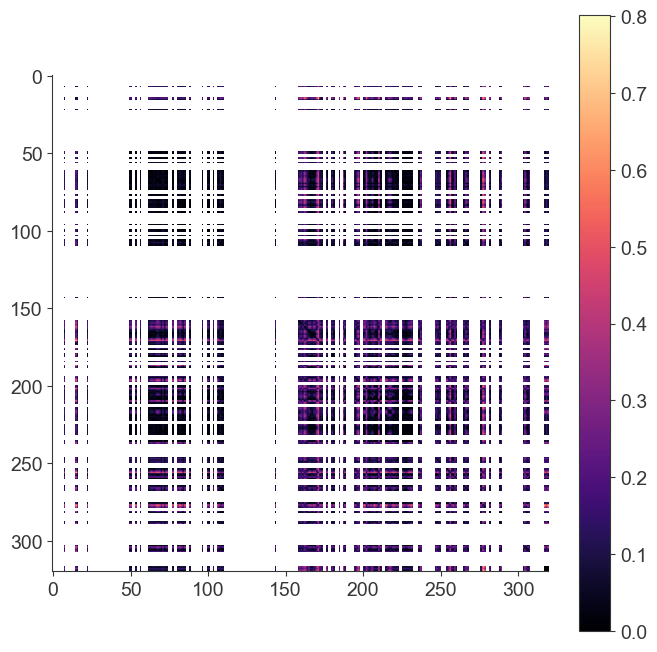

In [9]:
#We cluster all the data at once (both for R166Q and Q33S) to ensure
#consistent categorization between the two datasets 
#To do this, we first compute distances between all position pairs across both TYMS backgrounds

#We also calculate the distance to four seed vectors, these are used to define the initial set of 
#clusters (and epistatic categories) in the first round of kmeans.
seed = np.zeros([4,20])
seed[0] = seed[0] - 0.1   #negative epistasis
seed[1] = seed[1] + 0.1   #moderate positive epistasis
seed[2] = seed[2] + 0.2   #strong positive epistasis
cat = ['neg','pos','spos'] #epistatic categories: this order needs to match that of the seeds

Npos_adj = Npos - 1 #number of positions is adjusted to account for leaving out the first position
posDistMat = np.zeros([Npos_adj*2+len(seed),Npos_adj*2+len(seed)]) #matrix of distances

#function that takes in two vectors (corresponding to epistasis measurements at two positions)
#and returns the distance between them.
def calcDist(v1,v2):
    #sort each vector
    v1.sort()
    v2.sort()
    
    #trim each vector
    nan_array1 = list(np.isnan(v1))
    firstnan1 = nan_array1.index(True) if True in nan_array1 else len(v1)
    nan_array2 = list(np.isnan(v2))
    firstnan2 = nan_array2.index(True) if True in nan_array2 else len(v2)
    nan_trim = min(firstnan1,firstnan2)
    
    #we only calculate a distance for positions 
    #with 5 or more significant epistatic measurements
    if nan_trim < 5:
        return np.nan
    v1 = v1[:nan_trim]
    v2 = v2[:nan_trim]    
    
    
    #calculate and return the distance
    dist = np.sum(abs(v1 - v2))
    if dist > 0:
        dist = dist/len(v1)
    return dist

#iterate over the positions and fill in posDistMat
for p1 in range(Npos_adj):
    for p2 in range((p1+1),Npos_adj):
        #first the distance between the pair of
        #positions in the Q33S background
        #posDistMat[p1,p2] = calcDist(np.copy(epi['Q33S'][p1,:]), np.copy(epi['Q33S'][p2,:]))
        posDistMat[p1,p2] = calcDist(np.copy(epi_sig['Q33S'][p1,:]), np.copy(epi_sig['Q33S'][p2,:]))
        posDistMat[p2,p1] = posDistMat[p1,p2]
        
        #now the distance between the Q33S 
        #and R166Q background
        #posDistMat[p1,p2+Npos_adj] = calcDist(np.copy(epi['Q33S'][p1,:]), np.copy(epi['R166Q'][p2,:]))
        posDistMat[p1,p2+Npos_adj] = calcDist(np.copy(epi_sig['Q33S'][p1,:]), np.copy(epi_sig['R166Q'][p2,:]))
        posDistMat[p2+Npos_adj,p1] = posDistMat[p1,p2+Npos_adj]
        
        #now the distance between the Q33S 
        #and R166Q background - other order
        #posDistMat[p1+Npos_adj,p2] = calcDist(np.copy(epi['R166Q'][p1,:]), np.copy(epi['Q33S'][p2,:]))
        posDistMat[p1+Npos_adj,p2] = calcDist(np.copy(epi_sig['R166Q'][p1,:]), np.copy(epi_sig['Q33S'][p2,:]))
        posDistMat[p2,p1+Npos_adj] = posDistMat[p1+Npos_adj,p2]
        
        #finally the distance between the pair of
        #positions in the R166Q background
        #posDistMat[p1+Npos_adj,p2+Npos_adj] = calcDist(np.copy(epi['R166Q'][p1,:]), np.copy(epi['R166Q'][p2,:]))
        posDistMat[p1+Npos_adj,p2+Npos_adj] = calcDist(np.copy(epi_sig['R166Q'][p1,:]), np.copy(epi_sig['R166Q'][p2,:]))
        posDistMat[p2+Npos_adj,p1+Npos_adj] = posDistMat[p1+Npos_adj,p2+Npos_adj]
    
    #also calculate the distance to the seeds
    for k in range(len(seed)):
        #posDistMat[p1,Npos_adj*2+k] = calcDist(np.copy(epi['Q33S'][p1,:]),np.copy(seed[k]))
        posDistMat[p1,Npos_adj*2+k] = calcDist(np.copy(epi_sig['Q33S'][p1,:]),np.copy(seed[k]))
        posDistMat[Npos_adj*2+k,p1] = posDistMat[p1,Npos_adj*2+k]
        
        #posDistMat[p1+Npos_adj,Npos_adj*2+k] = calcDist(np.copy(epi['R166Q'][p1,:]),np.copy(seed[k]))
        posDistMat[p1+Npos_adj,Npos_adj*2+k] = calcDist(np.copy(epi_sig['R166Q'][p1,:]),np.copy(seed[k]))
        posDistMat[Npos_adj*2+k,p1+Npos_adj] = posDistMat[p1+Npos_adj,Npos_adj*2+k]
        
#plot the distance matrix, to get another sense of what the epistasis data look like.
plt.figure(figsize=(8,8))
plt.imshow(posDistMat,cmap='magma')
plt.colorbar()


#### Perform the K-means clustering, and check for convergence

Text(0, 0.5, 'Number of changes in classification')

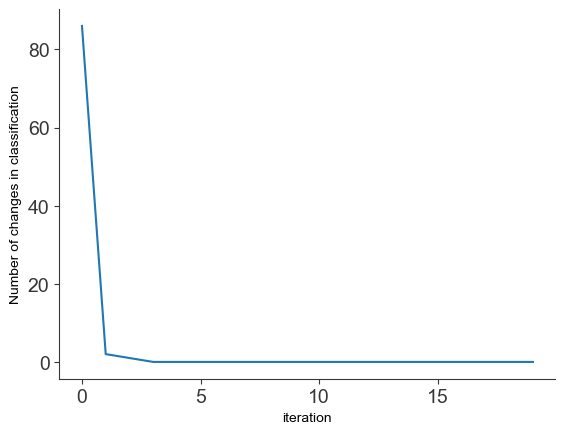

In [10]:
# Use k-means to cluster positions
# begin by assigning each position to one of four clusters based on the 
# 'seed' distances. we only cluster positions with measurements for 
# at least 5 mutations (25% of the data)

clust_assign = np.zeros(Npos_adj*2,dtype=int)
        
#initialize the clusters based on distance from the seed positions
for p in range(Npos_adj*2):
    s_dist = posDistMat[p,Npos_adj*2:Npos_adj*2+4]
    if ~np.isnan(s_dist[0]):
        clust_assign[p] = np.argmin(s_dist)
    else:
        clust_assign[p] = 100   #cannot be assigned... insufficient data

#print(clust_assign[clust_assign != 100])
#now iteratively refine the clusters
delta = []
it = 20
for i in range(it):
    clust_assign_new = np.zeros_like(clust_assign)
    for p in range(Npos_adj*2):
        if clust_assign[p] != 100:
            s_dist = []
            for c,cname in enumerate(cat):
                c_idx = [p for p,clust in enumerate(clust_assign) if clust == c]
                clust_dists = posDistMat[p,c_idx]
                clust_dists.sort()
                #s_dist.append(np.mean(clust_dists[0:10])) #Use nearest 10 nieghbors to compute distance
                s_dist.append(np.mean(clust_dists))       #use all cluster members to compute distance
            clust_assign_new[p] = np.argmin(s_dist)
        else:
            clust_assign_new[p] = 100
    delta.append(np.sum(clust_assign_new != clust_assign))
    clust_assign = np.copy(clust_assign_new)
    #print(clust_assign[clust_assign != 100])
                
#plot to check convergence
plt.plot(range(it),delta)
plt.xlabel('iteration')
plt.ylabel('Number of changes in classification')

#### Tally up the positions, and examine how many show a TYMS-dependent change in epistasis category

***** Epistatic clusters for Q33S: 
***** neg: (9 pos, 0.06)
2+5+9+13+17+20+24+28+31
***** pos: (60 pos, 0.38)
10+16+18+25+40+45+51+52+53+55+56+58+59+63+64+65+66+67+68+69+70+71+72+73+74+75+76+79+80+82+83+84+85+86+87+88+90+91+93+98+99+101+102+103+105+106+108+109+110+111+112+115+117+120+136+139+141+143+145+146
***** spos: (0 pos, 0.00)

***** nosig: (89 pos, 0.56)
3+4+6+7+8+11+12+14+15+19+21+22+23+26+27+29+30+32+33+34+35+36+37+38+39+41+42+43+44+46+47+48+49+50+54+57+60+61+62+77+78+81+89+92+94+95+96+97+100+104+107+113+114+116+118+119+121+122+123+124+125+126+127+128+129+130+131+132+133+134+135+137+138+140+142+144+147+148+149+150+151+152+153+154+155+156+157+158+159



***** Epistatic clusters for R166Q: 
***** neg: (1 pos 0.01)
85
***** pos: (84 pos 0.53)
2+3+5+8+9+10+11+12+13+16+17+18+20+21+23+24+25+26+28+29+32+33+38+39+42+44+45+47+48+49+50+51+52+53+55+56+58+59+60+61+62+63+64+65+66+67+69+70+71+72+73+74+75+76+79+80+82+88+90+91+92+94+97+98+99+101+102+104+108+109+111+112+115+117+119+120+126+12

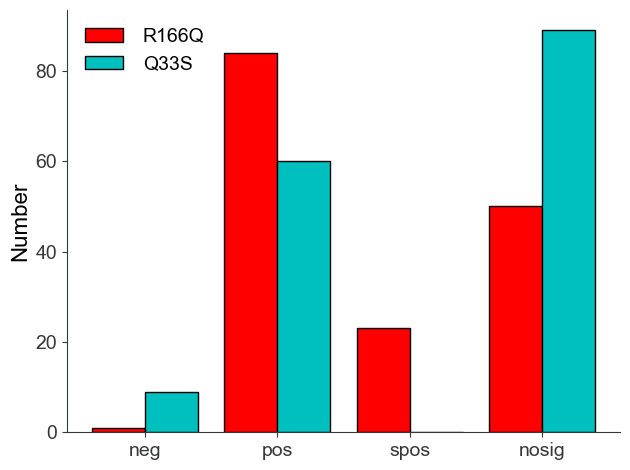

In [11]:
#setting up a dictionary to store the clustered positions
#(in a more convenient format)
clust = {}
cat = ['neg','pos','spos','nosig']
for ts in TYMS_mut[1:]:
    clust[ts] = {}
    for c in cat:
        clust[ts][c] = []
        
for i,ts in enumerate(['Q33S','R166Q']):
    for p in range(Npos_adj):
        if clust_assign[p+(i*Npos_adj)] < 3:
            clust[ts][cat[clust_assign[p+(i*Npos_adj)]]].append(p)
        else:
            clust[ts]['nosig'].append(p)
        
#print out the residue groups.
print("***** Epistatic clusters for Q33S: ")
for c in cat:
    print('***** %s: (%i pos, %1.2f)' % (c,len(clust['Q33S'][c]),len(clust['Q33S'][c])/Npos_adj))
    print('+'.join([str(k+2) for k in clust['Q33S'][c]]))
    
print('\n\n')
print("***** Epistatic clusters for R166Q: ")
for c in cat:
    print('***** %s: (%i pos %1.2f)' % (c,len(clust['R166Q'][c]),len(clust['R166Q'][c])/Npos_adj))
    print('+'.join([str(k+2) for k in clust['R166Q'][c]]))
    
#print out tallies on category switching
print('\n')
for c1 in cat:
    overlap_tally = 0
    for c2 in cat:
        overlap = len(set(clust['Q33S'][c1]).intersection(set(clust['R166Q'][c2])))
        if overlap > 0:
            print('%i Q33S %s epi positions become %s epi in the R166Q background' % (overlap,c1,c2))
            overlap_tally += overlap
    print('%i Q33S %s epi positions are non-epistatic in the R166Q background\n' % (len(clust['Q33S'][c1])-overlap_tally,c1))

print('\n ***************')
for c1 in cat:
    overlap_tally = 0
    for c2 in cat:
        overlap = len(set(clust['R166Q'][c1]).intersection(set(clust['Q33S'][c2])))
        if overlap > 0:
            print('%i R166Q %s epi positions become %s epi in the Q33S background' % (overlap,c1,c2))
            overlap_tally += overlap
    print('%i R166Q %s epi positions are non-epistatic in the Q33S background\n' % (len(clust['R166Q'][c1])-overlap_tally,c1))
     
#plot a bargraph of residue numbers in each category
R166Qcatpop = [len(clust['R166Q'][c]) for c in cat]
Q33Scatpop = [len(clust['Q33S'][c]) for c in cat]
x = np.arange(len(cat))
plt.bar(x-0.2,R166Qcatpop,width=0.4,color='r',edgecolor='k',label='R166Q')
plt.bar(x+0.2,Q33Scatpop,width=0.4,color='c',edgecolor='k',label='Q33S')
plt.xticks(x,cat); plt.ylabel('Number',fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('Figs/Hist_EpiCat.pdf')

#### Visualize the epistasis clusters as heatmaps

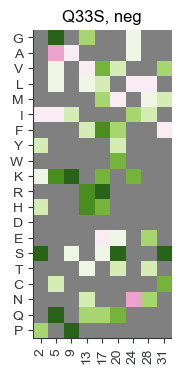

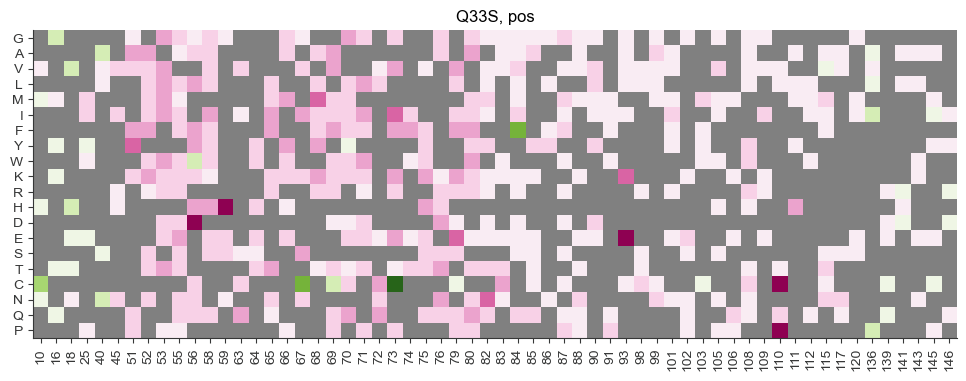

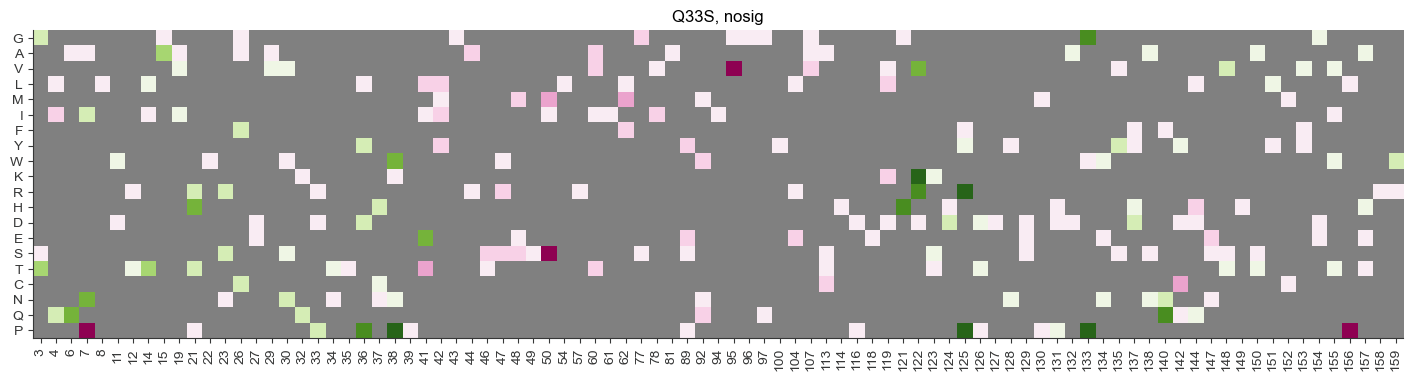

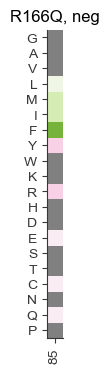

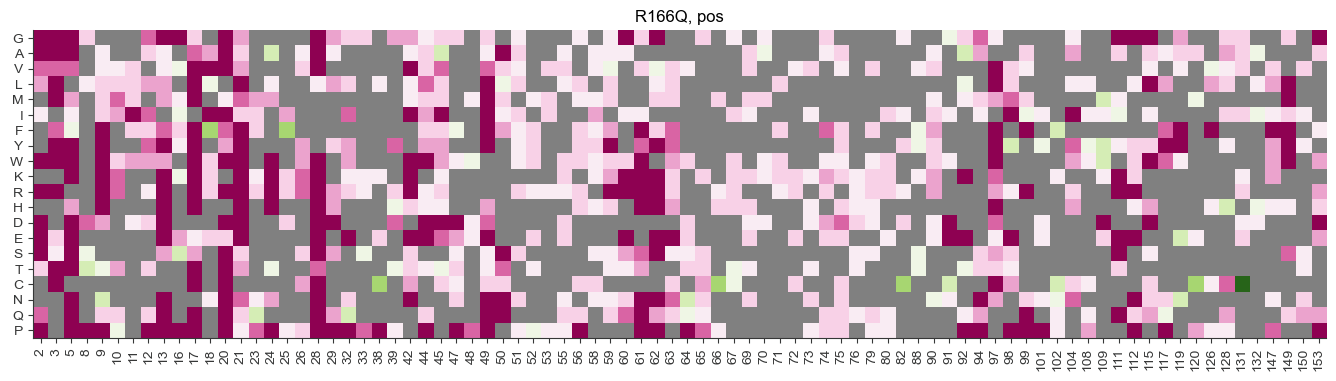

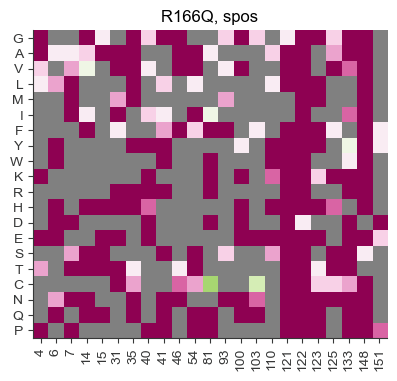

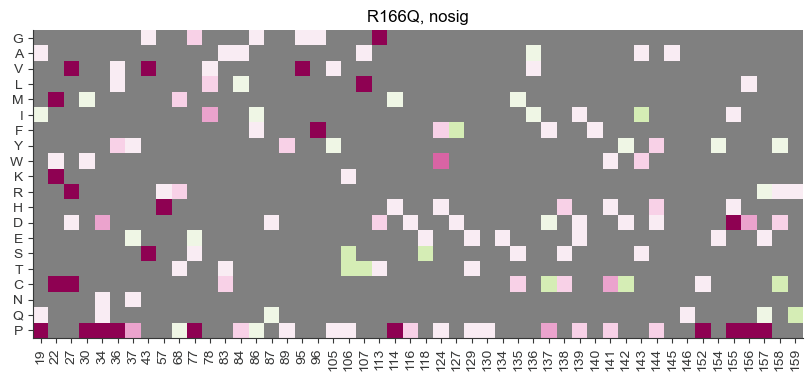

In [12]:
for ts in ['Q33S','R166Q']:
    for c in cat:
        if len(clust[ts][c]) == 0:
            continue
        elif len(clust[ts][c]) == 1:
            plt.figure(figsize=(1, 4))
        else:
            plt.figure(figsize = (int(len(clust[ts][c])/3),4))
        plt.imshow(epi_sig[ts][clust[ts][c],:].T,cmap=newmap,norm=norm)
        #plt.imshow(epi[ts][clust[ts][c],:].T,cmap=newmap,norm=norm)
        plt.yticks(np.arange(0,20),labels=AA[:-1],fontsize=10); 
        plt.xticks(np.arange(0,len(clust[ts][c])),\
                             labels=[str(p+2) for p in clust[ts][c]],\
                             rotation='vertical',fontsize=10)
        plt.title(ts+', '+c)
        fname = 'Figs/EpiHeatMap_Kmeans_'+ ts+'_'+c+'.pdf'
        plt.savefig(fname)

### Examine how epistasis varies as a function of distance from the active site

In [15]:
distance_from_ref = []
parser = PDBParser()
structure = parser.get_structure("1RX2", "Input/1RX2.pdb")
residues = [r for r in structure.get_residues() if r.get_id()[0] == " "]
fol = [r for r in structure.get_residues() if r.get_id()[0] == "H_FOL"]
#ref = residues[27]["CD2"].get_coord()
ref = fol[0]["C6"].get_coord() #consider the C6 atom of folate as the center of the active site
for k in range(1,Npos):
    res  = residues[k]["CA"].get_coord()
    distance_from_ref.append(np.linalg.norm(res-ref)) 
    
distsort = np.sort(distance_from_ref)
res_distsort = np.argsort(distance_from_ref)

In [16]:
#calculate CDF of entire protein as a reference
CDF_total = np.zeros(Npos_adj)
for i,r in enumerate(res_distsort):
    CDF_total[i] = CDF_total[i-1]
    CDF_total[i] += 1
CDF_total = CDF_total/Npos_adj

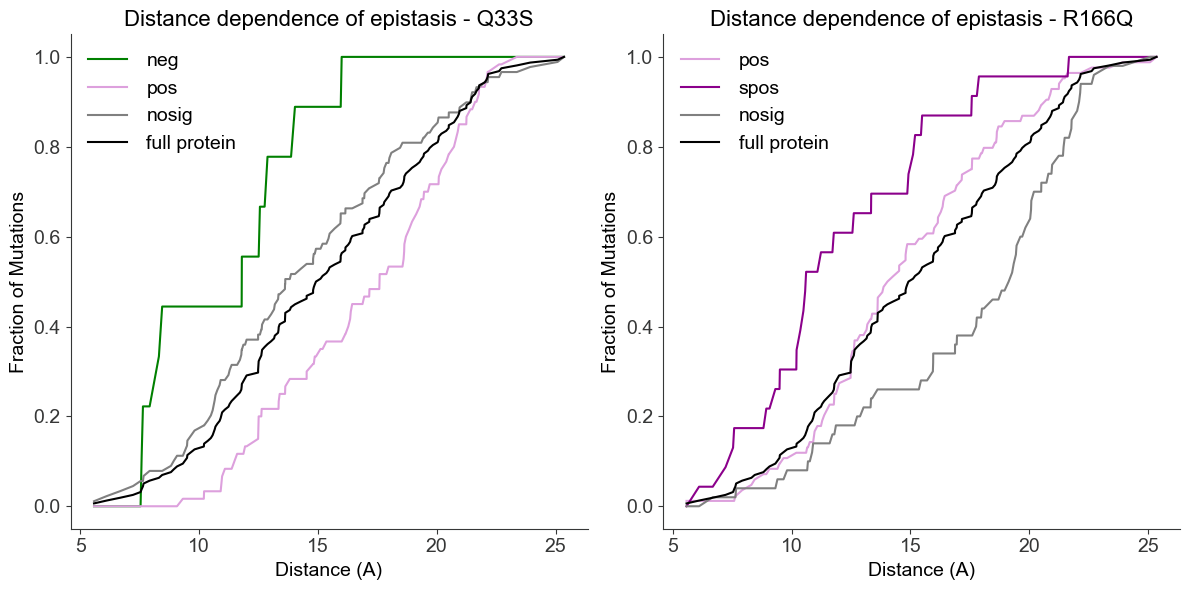

In [17]:
catcol = ['green','plum','darkmagenta','grey']
CDF = {}
for t in TYMS_mut[1:]:
    CDF[t] = {}
    for c in cat:
        if len(clust[t][c]) > 5:
            CDF[t][c] = np.zeros(Npos_adj)
            for i,r in enumerate(res_distsort):
                CDF[t][c][i] = CDF[t][c][i-1]
                if r in clust[t][c]:
                    CDF[t][c][i] += 1
            CDF[t][c] = CDF[t][c]/len(clust[t][c])
                
plt.figure(figsize=(12,6))
plt.subplot(121)

for i,c in enumerate(cat):
    if len(clust['Q33S'][c]) > 5:
        plt.plot(distsort,CDF['Q33S'][c],color=catcol[i],label=c)
plt.plot(distsort, CDF_total, color='k', label='full protein')
plt.legend()
plt.xlabel('Distance (A)',fontsize=14)
plt.ylabel('Fraction of Mutations', fontsize=14)
plt.title('Distance dependence of epistasis - Q33S',fontsize=16)

plt.subplot(122)
for i,c in enumerate(cat):
    if len(clust['R166Q'][c]) > 5:
        plt.plot(distsort,CDF['R166Q'][c],color=catcol[i],label=c)
plt.plot(distsort, CDF_total, color='k', label='full protein')
plt.legend()
plt.xlabel('Distance (A)',fontsize=14)
plt.ylabel('Fraction of Mutations', fontsize=14)
plt.title('Distance dependence of epistasis - R166Q',fontsize=16)
plt.tight_layout()
plt.savefig('Figs/EpiDistDistr.pdf')

### A closer examination of select positions with sign epistasis

The goal is to inspect those mutations that exhibit sign epistasis (to TYMS background), and choose a few for futher experimental characterization. We select mutations with statistically significantly positive epistasis in the R166Q background and statistically negative epistasis in the Q33S background. Among these, we then filter on the magnitude of epistatic effect (to chose mutations with a large differential between TYMS backgrounds), and the overall growth rate (to chose mutations that have modest growth rate defects and likely retain function). 

*** Positions with sign epistasis: 
2+5+9+13+17+20+24+28+31
*** Statistically significant mutations at sign-switching positions:
2P+2S+5Q+5G+5K+9K+9P+9I+13H+13F+13R+13N+13G+13Q+17V+17H+17R+17K+17M+17Q+17L+17F+20Q+20T+20Y+20W+20S+20F+20V+24K+28T+28E+28N+31C+31V+31M
*** Now filtered on growth rate and epistatic difference:
5K+13H+13G+13Q+17V+17H+17K+17Q+17F+20Q+20T+20W+24K+28E+31C+31V
*** Final list of mutations for experimental characterization: 
I5K+V13H+E17V+M20Q


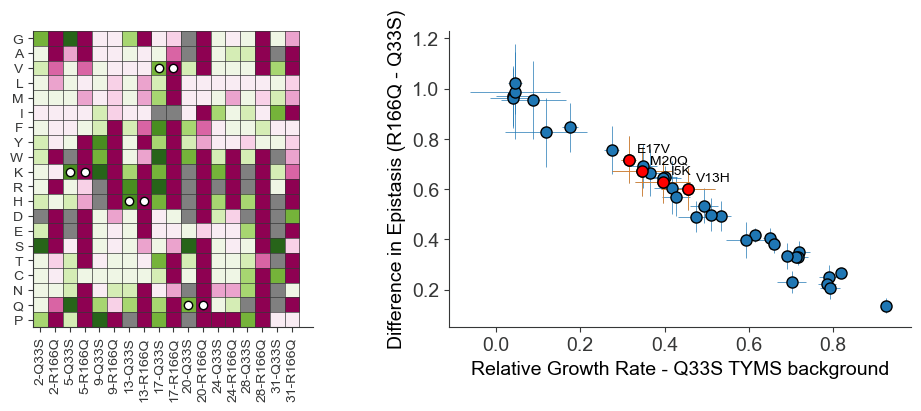

In [18]:
pos_r166q = set(clust['R166Q']['pos']).union(set(clust['R166Q']['spos']))
episwitch_pos = pos_r166q.intersection(set(clust['Q33S']['neg']))
print('*** Positions with sign epistasis: ')
print('+'.join([str(k+2) for k in episwitch_pos]))
combi_mat = np.zeros((2*len(episwitch_pos),len(AA[:-1])))
labels = []
labels2 = []
grQ33S_alamut, grR166Q_alamut, grWT_alamut = [],[],[]
grQ33S_alamut_std, grR166Q_alamut_std, grWT_alamut_std = [],[],[]
for i,k in enumerate(episwitch_pos):
    labels.append(str(k+2)+'-Q33S')
    labels.append(str(k+2)+'-R166Q')
    combi_mat[2*i,:] = epi['Q33S'][k,:]
    combi_mat[2*i+1,:] = epi['R166Q'][k,:]

#of these, identify the subset of mutations that are SIGNIFICANTLY negative in 
#the Q33S background, and SIGNIFICANTLY positive in the R166Q background
sigSignSwitchMut = list(set(sig_neg['Q33S']).intersection(set(sig_pos['R166Q'])))
sigSignSwitchMut_sort = [sigSignSwitchMut[k] for k in np.argsort([int(m[:-1]) for m in sigSignSwitchMut])]
sigSignSwitchMut_clust = [s for s in sigSignSwitchMut_sort if int(s[:-1])-2 in episwitch_pos]
print("*** Statistically significant mutations at sign-switching positions:")
print('+'.join(sigSignSwitchMut_clust))

#Now we set some empirical cutoffs
gr_cutoff = 0.3
epi_diff_cutoff = 0.4
moi = []
for i,m in enumerate(sigSignSwitchMut_clust):
    p = int(m[:-1])-2
    a = AA.index(m[-1])
    if (gr_filt['Q33S'][p,a] > gr_cutoff) and (abs(epi['R166Q'][p,a] - epi['Q33S'][p,a]) > epi_diff_cutoff):
        moi.append(m)
print("*** Now filtered on growth rate and epistatic difference:")
print('+'.join(moi))

#Select a handful of these mutations for experimental characterization
expt_mut = ['I5K','V13H','E17V','M20Q']
print("*** Final list of mutations for experimental characterization: ")
print('+'.join(expt_mut))

#plot the sign switching mutations, highlight the mutations chosen for further
#experimental characterization
plt.figure(figsize = (10,4), num='hmut')
plt.subplot(121)
plt.imshow(combi_mat.T,cmap=newmap,norm=norm)
plot_style.grid_maker(combi_mat.T,'hmut')
for m in expt_mut:
    x = [i for i,l in enumerate(labels) if m[1:-1]+'-' in l]
    y = AA.index(m[-1])
    plt.plot(x[0],y,'ow',markersize=6,mec='k')
    plt.plot(x[1],y,'ow',markersize=6,mec='k')
plt.yticks(np.arange(0,20),labels=AA[:-1],fontsize=10); 
plt.xticks(np.arange(0,len(labels)),\
                     labels=labels,\
                     rotation='vertical',fontsize=10)

plt.subplot(122)
epi_diff,epi_diff_std,gr_vals,gr_vals_std = [],[],[],[]
epiE_diff,epiE_diff_std,grE_vals,grE_vals_std = np.zeros(len(expt_mut)),np.zeros(len(expt_mut)),\
                                                np.zeros(len(expt_mut)),np.zeros(len(expt_mut))
for m in sigSignSwitchMut_clust:
        p = int(m[:-1])-2
        a = AA.index(m[-1])
        gr_vals.append(gr_filt['Q33S'][p,a])
        gr_vals_std.append(gr_filt_std['Q33S'][p,a])
        epi_diff.append(epi['R166Q'][p,a] - epi['Q33S'][p,a])
        epi_diff_std.append(np.sqrt(epi_std['R166Q'][p,a]**2 + epi_std['Q33S'][p,a]**2))
        if wt_aa_seqfull[p+1]+m in expt_mut:
            ix = expt_mut.index(wt_aa_seqfull[p+1]+m)
            grE_vals[ix]=gr_filt['Q33S'][p,a]
            grE_vals_std[ix] = gr_filt_std['Q33S'][p,a]
            epiE_diff[ix] = epi['R166Q'][p,a] - epi['Q33S'][p,a]
            epiE_diff_std[ix] = np.sqrt(epi_std['R166Q'][p,a]**2 + epi_std['Q33S'][p,a]**2)
        
plt.errorbar(gr_vals,epi_diff,xerr=gr_vals_std,yerr=epi_diff_std,fmt='o',ms=8,mec='k',elinewidth=0.5)
plt.errorbar(grE_vals,epiE_diff,xerr=grE_vals_std,yerr=epiE_diff_std,fmt='o',ms=8,mfc='r',mec='k',elinewidth=0.5)
for i in range(len(grE_vals)):
    plt.text(grE_vals[i]+.02,epiE_diff[i]+.03,expt_mut[i])

plt.xlabel('Relative Growth Rate - Q33S TYMS background',fontsize=14)
plt.ylabel('Difference in Epistasis (R166Q - Q33S)',fontsize=14)
plt.savefig('Figs/SignSwitch_ExptMut.pdf')
plt.tight_layout()

### Write out the epistasis values and position groups to a pickle file

In [19]:
fout = open('Output/Epistasis.pkl','wb')
epi_groups = {}
epi_groups['clust'] = clust
epi_groups['distsort'] = distsort
epi_groups['res_distsort'] = res_distsort
epi_groups['epi_sig'] = epi_sig
epi_groups['epi'] = epi
epi_groups['epi_std'] = epi_std
epi_groups['gr_filt'] = gr_filt
epi_groups['gr_filt_std'] = gr_filt_std
epi_groups['WTAAmask'] = WTAAmask
pickle.dump(epi_groups,fout, protocol=pickle.HIGHEST_PROTOCOL)
fout.close()
        
#in csv format (for sharing the data more broadly)
fout = open('Output/Epistasis.txt','w')
fout.write('mut\t%s_epi_avg\t%s_epi_std\t%s_epi_pval\t%s_epi_avg\t%s_epi_std\t%s_epi_pval\n'% \
           (TYMS_mut[1],TYMS_mut[1],TYMS_mut[1],TYMS_mut[2], \
            TYMS_mut[2],TYMS_mut[2]))

for pos_ix in range(Npos-1):
    for aa_ix in range(NAA_nostop):
        mut = wt_aa_seqfull[pos_ix+1]+str(pos_ix+2)+AA[aa_ix]
        fout.write('%s\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\n'%\
                  (mut,epi[TYMS_mut[1]][pos_ix,aa_ix],epi_std[TYMS_mut[1]][pos_ix,aa_ix],\
                  epi_pvals[TYMS_mut[1]][pos_ix,aa_ix],epi[TYMS_mut[2]][pos_ix,aa_ix],\
                  epi_std[TYMS_mut[2]][pos_ix,aa_ix],epi_pvals[TYMS_mut[2]][pos_ix,aa_ix]))
        
fout.close()